# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #7
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 23th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Kidney Cancer Data Revisited
In this problem we will work with the US Kidney Cancer Data set (by county). This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

In lecture, we've discussed the potential (and significant) draw backs of drawing conclusions based on raw cancer rates. Addressing these draw backs, we proposed using a Bayesian model to model the data. In the following, you will implement two Bayesian models and examine the adjusted cancer rates per county resulting from these models.

### Part A: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

(1) Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters. To do this, consider the **prior-predictive** distribution (also called evidence, the denominator normalization of bayes theorem) of the model: 

$$p(y) = \int p(y \vert \theta) p(\theta) d \theta$$.

(This is as opposed to the posterior predictive: $\int p( y \vert \theta) p(\theta \vert D) d\theta$. Not that in conjugate models such as ours, these two distributions have the same form)

For this model, the prior-predictive is a negative binomial. By matching the mean and the variance of the negative binomial to that from the data you can find $\alpha$ and $\beta$. (Hint: You need to be careful with the $5n_j$ multiplier.) Why the prior-predictive? Because you then "havent seen" individual county data yet.

(2) Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green. 

(**Note:** This is the plot (without the corrected green estimates) shown in the lecture notes for this dataset. We have provided the code to produce this plot, which you are free to use or to ignore.)


(3) Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might find it helpful to review the in-class discussion on this dataset. You might also find it helpful to follow the Rat Tumor Baysian model example.)

In [1]:
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('classic')

# data_df is the dataframe of your data
# estimates is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.05, color="grey")
    # NOTE:if you have an older pandas version you should use 
    # "data_df.sort" instead of "data_df.sort_values"
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="red", ax=ax, logx=True)
    ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.04, color="green")
    ax.set_ylim([-0.0001, 0.0003])
    ax.grid()

df = pd.read_csv('./kcancer.csv')
df.head(6)

,state,fips,county,countyfips,dc,pop,pct_mortality
0,ALABAMA,1,AUTAUGA,1001,1.0,64915.0,0.000015
1,ALABAMA,1,BALDWIN,1003,15.0,195253.0,0.000077
2,ALABAMA,1,BARBOUR,1005,1.0,33987.0,0.000029
3,ALABAMA,1,BIBB,1007,1.0,31175.0,0.000032
4,ALABAMA,1,BLOUNT,1009,5.0,91547.0,0.000055
5,ALABAMA,1,BULLOCK,1011,0.0,8197.0,0.000000


We can match the mean and variance of the prior to the moments of the gamma distribution to calculate the $\alpha$ and $\beta$ lambdas. 

These values are calculated as:

$$ \mu = \frac{\alpha}{\beta} $$

$$ \sigma^2 = \frac{\alpha}{\beta^2} $$

In [2]:
# get N, the number of rows in the cancer dataset
N = df.shape[0]

# calculate the mean mu and variance sigma2
mu = (df['dc']/(5*df['pop'])).mean()
sigma2 = (df['dc']/(5*df['pop'])).var()

sum_yi = df['dc'].sum()
print (mu, sigma2)

beta_emp = mu/sigma2
alpha_emp = mu*beta_emp

print ("\n")
print (alpha_emp, beta_emp)

print ("\n")
print(df['dc'].sum())

1.1573104708217248e-05 1.0113340787478882e-10


1.3243571575594935 114434.04263154732


25999.0


# 1A part 1 - Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters.

In [3]:
lambdas = []
for i in range(N):
    y_j = df['dc'].iloc[i]
    n_j = df['pop'].iloc[i]
    lambdas.append(np.random.gamma(alpha_emp+y_j, 1/(beta_emp+5*n_j), size=10000).mean())

# need the per year rate
lambdas = np.array(lambdas) 

ESTIMATE $\alpha$ AND $\beta$ BASED ON THE PRIOR PREDICTIVE

$$\mu = \frac{(\alpha + \sum y_i)}{(\beta+5*n_j)}$$

$$\sigma^2 = \frac{(\alpha + \sum y_i)}{(\beta + 5*n_j)^2}(\beta +5*n_j+1)$$

Substituting $\mu$, we get the following:

$$\sigma^2 = \frac{\mu(\beta +5*n_j+1)}{(\beta + 5*n_j)}$$

$$(\beta + 5*n_j)\sigma^2 = \mu(\beta +5*n_j+1)$$

$$ (\sigma^2 - \mu) \beta = -5*n_j(\sigma^2) +  5*n_j \mu + \mu $$

From this we can estimate $\alpha$ and $\beta$:

$$\beta = \frac{-5*n_j(\sigma^2) +  5*n_j \mu + \mu}{(\sigma^2 - \mu)} $$$$ \alpha = \mu(\beta+5*n_j) - \sum y_i $$

In [4]:
# calculate the mean and variance
mu_ = df['dc'].mean()
sigma2_ = df['dc'].var()
n_j_mean = df['pop'].mean()
beta1 = (5*df['pop']*df['dc']).mean()/(sigma2_ - mu_)
print (beta1)

alpha1 = ((beta1*df['dc'])/(5*df['pop'])).mean()
print (alpha1)

beta_ = -(mu_)/(sigma2_ - mu_*5*n_j_mean)
print (1/beta_, beta_emp)

alpha_ = mu_*5*beta_*n_j_mean
print (alpha_)

113737.85828851341
1.3163001432613421
802494.4817020977 114434.04263154732
8.352453933303753


# Now, estimate the thetas by matching the mean and the variance of the prior to the moments of the gamma distribution:

In [5]:
lambdas = []
for i in range(N):
    y_j = df['dc'].iloc[i]
    n_j = df['pop'].iloc[i]
    lambdas.append(np.random.gamma(alpha_+y_j, 1/((1/beta_)+5*n_j), size=10000).mean())

# need the per year rate
lambdas = np.array(lambdas) 
print (lambdas[0])

8.30760540232e-06


# 1A part 2 - Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green.

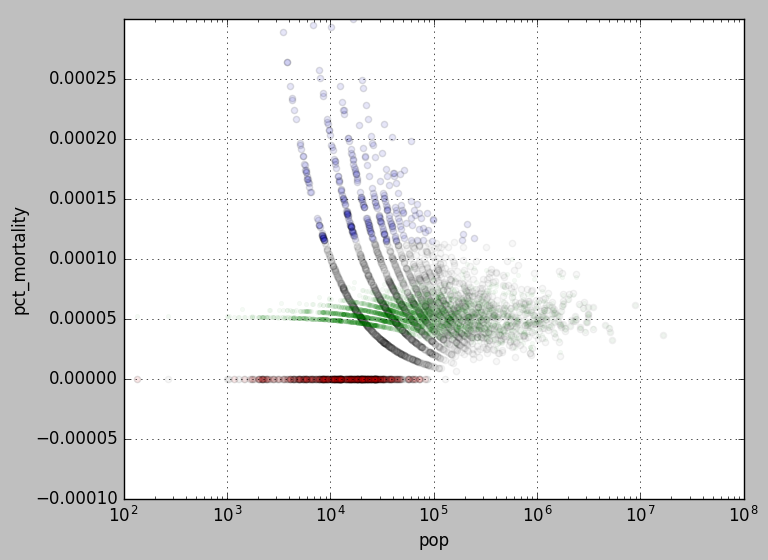

In [6]:
scatter_plot_cancer_rates(df, np.array(lambdas))

# 1A part 3 -  Explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves

<b>MY ANSWER:</b>

The raw mortality rates can vary widely, especialyl in counties with small populations. In less populated counties, a small increase in death count can result in a comparatively high mortality rate. This is therefore not a very meaningful metric for looking at mortality rates across different counties.
Instead it is more preferable to use the poterior means to estimate cancer rates - this assumes that mortality rates are from a prior Gamma distribution with estimated parameters. The mortality rates are clustered at the group mean and there are fewer outliers. This also eliminates the effect of the popuation size on the mortality rate

### Part B: Full Bayes
Rather than estimating the hyperparameters $\alpha, \beta$ from the data, in a full Bayesian model we would put additional priors on quantities of which we are uncertain. That is, we can model the kidney cancer rates using a *hierarchical model*.
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Gamma(a, b)\\
\beta &\sim Gamma(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 


(1) Analytically derive the full conditional, up constants that are inconsequential for sampling, for each variable in the model. 
  
  A possible set of correct final forms of your conditionals looks like the following:
      
\begin{aligned}
p(\theta_j | y, \theta_{-j}, \alpha, \beta) &\propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
p(\alpha, \beta | y, \theta) &\propto \Gamma(\alpha)^{-N}\beta^{N\alpha}\prod_j \theta_j^{\alpha}  \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}





# 1B part 1 -

To start, we use the joint pdf to obtain the individual conditionals:

$$\begin{aligned}
p(\theta_j, y_j, \mu, \sigma,\alpha, \beta, a,b,c,d) =  p(y_j|\theta_j)*p(\theta_j|\alpha, \beta)* p(\alpha|a,b)*p(\beta|c,d)*p(a)*p(b)*p(c)*p(d)
\end{aligned}$$

$$\begin{aligned}
p(\theta_j | y_j,  \mu, \sigma) = p(y_j|\theta_j)*p(\theta_j|\alpha, \beta) \\
\end{aligned}$$

Here a Poisson distribution is used to model the likelihood, and the prior conditional is modeled with a Gamma function.  Because of this, the posterior for $\theta$ is also a Gamma function.  This can be shown as follows: 

$$\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \left(\frac{{5n_j\theta_j}^y_j e^{-5n_j\theta_j}}{y_j!}\right)* \left(\frac{{\beta}^\alpha}{\Gamma(a)}\right)\theta_j^{\alpha -1}e^{-\beta\theta_j}\\
\end{aligned}$$

Grouping similar terms and simplifying: 


$$\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \theta_j^{y_j+\alpha -1} e^{-(5n_j + \beta)\theta_j}\\
\end{aligned}$$

$$\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \left(\frac{(\beta+5n_j)\theta_j^{y_j+\alpha -1} e^{-(5n_j + \beta)\theta_j}}{\Gamma(\alpha + y_i)}\right)\\
\end{aligned}$$

$$\begin{aligned}
p(\theta_j | y_j, \alpha, \beta) \propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
\end{aligned}$$


We can then derive the conditional distribution for $\alpha$ and $\beta$:

$$\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \prod_j p(\theta_j|\alpha, \beta)*p(\alpha| a,b)*p(\beta| c,d)
\end{aligned}$$

Substituting in the Gamma functions:

$$\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \prod_j \left(\frac{{\beta}^\alpha}{\Gamma(\alpha)}\theta_j^{a-1}e^{-\theta_j \beta}\right) \left(\frac{{b}^a}{\Gamma(a)}\alpha^{a-1}e^{-\alpha b}\right) \left(\frac{{d}^c}{\Gamma(c)}\beta^{c-1}e^{-\beta d}\right)
\end{aligned}$$

Here we obtain the final conditionals:

$$\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \left(\frac{{b}^a}{\Gamma(a)}\alpha^{a-1}e^{-\alpha b}\right) \left(\frac{{d}^c}{\Gamma(c)}\beta^{c-1}e^{-\beta d}\right) \beta^{N\alpha}\Gamma(\alpha)^{-N} \prod_j \left(\theta_j^{a-1}\right)e^{-\beta\sum_j\theta_j}
\end{aligned}$$

$$\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \left(\frac{{b}^a}{\Gamma(a)}\alpha^{a-1}e^{-\alpha b}\right) \left(\frac{{d}^c}{\Gamma(c)}\beta^{c-1}e^{-\beta d}\right) \frac{{\beta}^{N\alpha}}{\Gamma(\alpha)^N} \prod_j \left(\theta_j^{a-1}e^{-\theta_j \beta}\right)
\end{aligned}$$

$$\begin{aligned}
p(\alpha, \beta | y_j, \theta_j, \sigma^2) \propto \beta^{N\alpha}\Gamma(\alpha)^{-N}\prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}$$

Lastly we derive the product of Gamma probability functions for each theta:

$$\beta^{N\alpha}\Gamma(\alpha)^{-N}\prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\}$$

(2) Implement a Metropolis-Hastings-in-Gibbs sampler (like in rat tumors) to produce sets of theta-values, $\{ \theta_j: j = 1, \ldots, N\}$. Note that for updating some variables, you may need to use a Metropolis-Hastings step (see Rat Tumor example). 

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = \alpha_{\text{emperical bayes}}, \beta_0 = \beta_{\text{emperical bayes}}$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10
  
  We do not guarantee convergence after 100,000 sets of samples under these conditions. In fact, ***convergence in a untweaked sampler maybe unlikely after only 100,000 Gibbs sweeps***. 

  You are responsible for performing your own convergence tests and diagnostics.

  **Note:** to sanity check your implementation, you may wish to implement this model in PyMC3 and compare your results. Note that because you model is hand tuned to deal with the conditionals and to sample straight away from the Gamma's, it will likely run faster)
  
  

- **Extra Credit:** Tweak the settings in your sampler (including number of sweeps) in order to achieve convergence. For example, do you need to sample $\alpha$ and $\beta$ jointly? Can sampling them individually speed up your sampler? Only do this after you have a complete homework. It is a rabbit hole.





# 1B part 2 - Implement a Metropolis-Hastings-in-Gibbs sampler

In [7]:
# define the proposal distribution provided
def proposal(alp,bet):
    cov = [[0.001, 0], [0, 1000]]
    return np.random.multivariate_normal([alp,bet], cov)

# set the lambdas
a = 9
b = 6
c = 9
d = 0.00001

prior_a = stats.gamma(a,scale=1.0/b)
prior_b = stats.gamma(c,scale=1.0/d)

likelihood_theta = lambda alp, bet: stats.gamma(alp,scale=1.0/bet)

# get the number of samples for the kidney cancer dataset
num_lambdas=df.shape[0]

# sampling from conditional posterior for the theta
draw_lambdas = lambda a_,b_: stats.gamma.rvs(a_+df['dc'],scale=1.0/(b_+5*df['pop']), size=num_lambdas)

# conditional posterior (pdf) for alpha beta
def log_cond_alpha_beta(alp,bet, lambdas):
    return np.sum(np.log(likelihood_theta(alp, bet).pdf(lambdas))) + np.log(prior_a.pdf(alp)) + np.log(prior_b.pdf(bet))

# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha_beta(alp,bet,lambdas,proposal, accepts):
    alp_star, bet_star = proposal(alp, bet)  # propose a new alpha and beta
    num = log_cond_alpha_beta(alp_star,bet_star, lambdas) 
    den = log_cond_alpha_beta(alp,bet, lambdas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha_beta'] = accepts['alpha_beta'] + accepted
    if accepted:
        return alp_star, bet_star
    else:
        return alp, bet

In [8]:
# use 100,000 gibbs sweeps
totaltraces=100000

# and a burnin of 10%
burnin=0.1*totaltraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
lambdas=np.empty((totaltraces, num_lambdas))

# set the start positions
alphas[0]=alpha_emp
betas[0]=beta_emp
lambdas[0,:] = 0.0001

In [9]:
# Run the sampler - 
accepteds={'alpha_beta':0}
for m in np.arange(1,totaltraces):
    if (m%10000 == 0):
        print("Completed", m, "iterations.")
    alphas[m], betas[m] = draw_alpha_beta(alphas[m-1],betas[m-1],lambdas[m-1,:], proposal, accepteds)
    # For the lambdas, take both alpha and beta from the current step
    lambdas[m,:] = draw_lambdas(alphas[m],betas[m])
print ("~~Sampler computation finished!~~")

Completed 10000 iterations.
Completed 20000 iterations.
Completed 30000 iterations.
Completed 40000 iterations.
Completed 50000 iterations.
Completed 60000 iterations.
Completed 70000 iterations.
Completed 80000 iterations.
Completed 90000 iterations.
~~Sampler computation finished!~~


In [10]:
accepteds['alpha_beta']/totaltraces

0.60849

# 1B part 3 - Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.

In [11]:
#remove burnin samples and thin
thin=10
burnin=1000
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
lambdastrace=lambdas[burnin+1:totaltraces:thin,:]
print(lambdastrace.shape, alphatrace.shape)

(9900, 3113) (9900,)


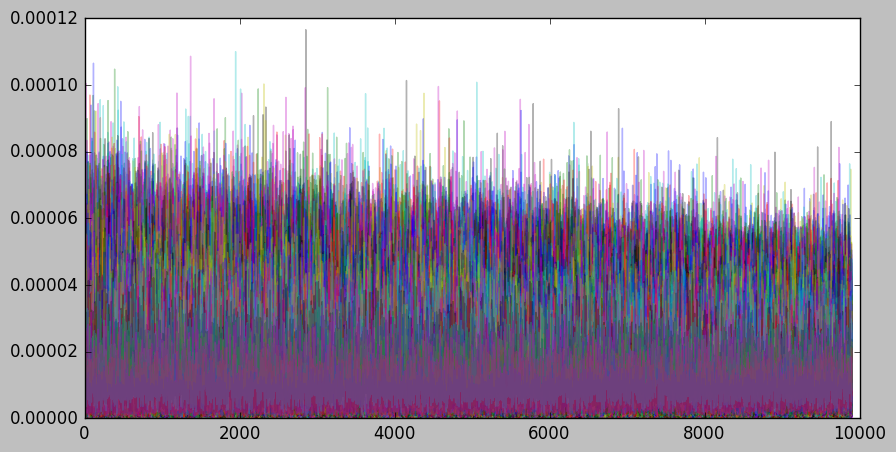

In [12]:
plt.figure(figsize=[10,5])
plt.plot(lambdastrace, alpha=0.3);

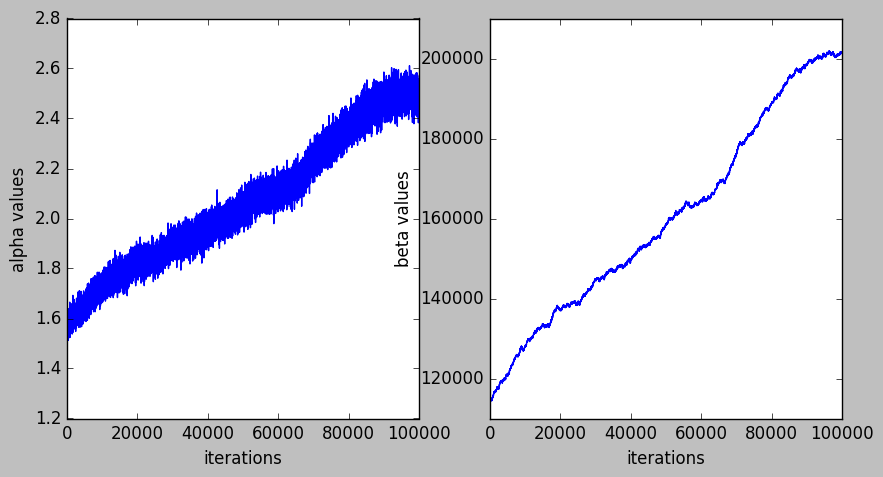

In [13]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.plot(alphas)
plt.ylabel('alpha values')
plt.xlabel('iterations')
plt.subplot(1,2,2)
plt.plot(betas)
plt.ylabel('beta values')
plt.xlabel('iterations')

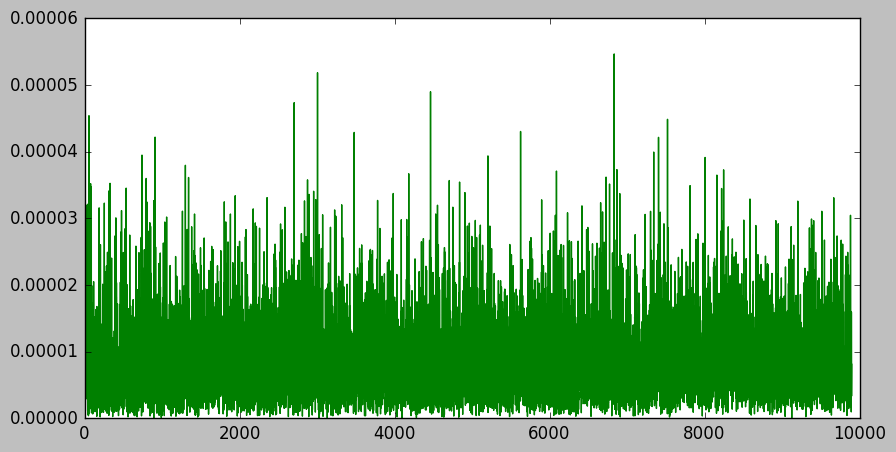

In [14]:
plt.figure(figsize=[10,5])
plt.plot(lambdastrace[:, 100], color='g')

It looks like there is reasonable convergence for our alphas, betas, and lambdas(thetas) since the traceplots aren't showing a huge amount of autocorrelation. 

We can further investigate this:

In [15]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

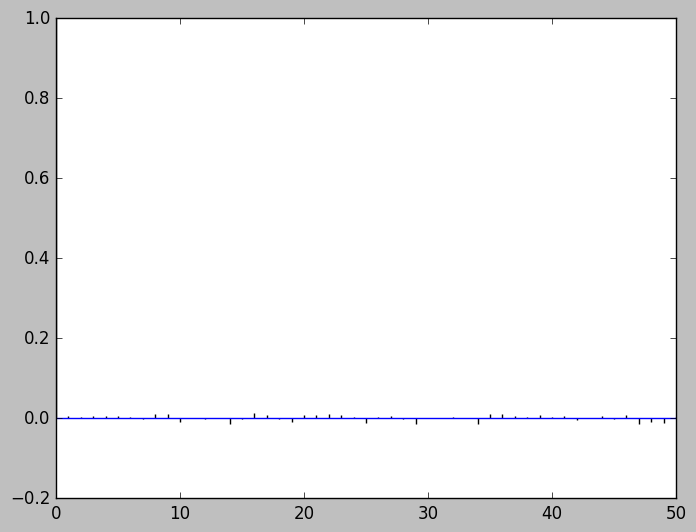

In [16]:
corrplot(lambdastrace[:, 100])

(3) Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.

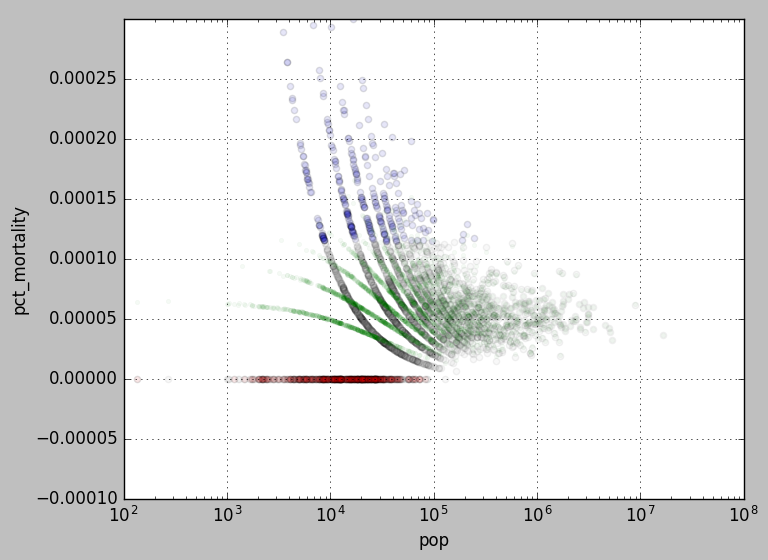

In [17]:
scatter_plot_cancer_rates(df, np.mean(lambdastrace, axis=0))

1B part 3 - FINAL ANSWER:

The full Bayesian Model has a more variation in population and mortality rates around the group mean, when compared to the purely empirical Bayes. This is because of the hyperpriors on alpha and beta, which increases the variance because these are uncertainties. The higher variance helps reduce excessively high or low mortality rates due to the effect of a population size. This is seen in the smaller range in the mortality percentages when compared with the empirical incidence rates. The full Bayesian model is a useful alternative to Empirical Bayes in that it better accounts for the uncertainty in data collected.